In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import database_manager as dbm
import pandas as pd
import Scott_Princeton
import numpy.random as rand

Artificial Data formation and Alteration 

In [3]:

def lorentzian(phi, gamma, x0 = 0.5):
    return (gamma/((phi - x0)**2 + gamma**2))/np.pi


def generate(n_samples, n_bins, noise = True):
    max_subpulses = 6
    phi = np.linspace(0, 1, n_bins)
    pulses = np.zeros((n_samples, n_bins))
    locs = np.zeros((n_samples, max_subpulses + 1))
    gammas = np.copy(locs)
    amps = np.copy(locs)

    for i in range(n_samples):
        gamma = rand.choice(np.linspace(0.001, 0.05, 1000))
        pulse = lorentzian(phi, gamma)
        pulse /= max(pulse)
        pulse = np.zeros(1024)

        subpulses = rand.randint(0, max_subpulses + 1)
        subpulses = max_subpulses 
        #subpulses
        for j in range(subpulses):
            gamma_sub = rand.choice(np.linspace(0.001, 0.1, 1000))
            loc_sub = 0.5 + rand.normal(0, 0.1)
            #loc_sub = rand.choice(np.linspace(0.1, 0.9, 1024))
            subpulse = lorentzian(phi, gamma_sub,loc_sub)
            amp = rand.choice(np.linspace(0.1, 0.9))
            subpulse *= amp/max(subpulse)
            pulse += subpulse

            locs[i, j + 1] = loc_sub
            gammas[i, j + 1] = gamma_sub
            amps[i, j + 1] = amp

        if noise:
            rms = rand.choice(np.linspace(0.001, 0.3, 3000))
            pulse += rand.normal(0, rms, n_bins)

        pulses[i] = pulse
        locs[i, 0] = 0.5
        gammas[i, 0] = gamma
        amps[i, 0] = 1

    return pulses, locs, gammas, amps

def generate_dummy(n_samples, n_bins):
    phi = np.linspace(0, 1, n_bins)
    pulses = np.zeros((n_samples, n_bins))
    locs = np.zeros(n_samples)

    for i in range(n_samples):

        pulse = np.zeros(1024)

        gamma_sub = rand.choice(np.linspace(0.001, 0.05, 1000))
        loc_sub = rand.choice(np.linspace(0.1, 0.9, 1024))
        subpulse = lorentzian(phi, gamma_sub,loc_sub)
        amp = rand.choice(np.linspace(0.1, 0.9))
        subpulse *= amp/max(subpulse)
        pulse += subpulse

        locs[i] = loc_sub
        pulses[i] = pulse

    return pulses, locs

Main Code 

In [ ]:
#  Example from Git hub 
#  link to the github reference:
#  https://github.com/pavelkulich/SignalAnalysis/blob/36a35c6a9e37a9ce65d6bb1e6098652671018a90/spectrum.py  

def dft(x):
    """
    Compute the discrete Fourier Transform of the 1D array x
    :param x: (array)
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    return np.dot(e, x)


def plot_frequency(x, y, N):
    plt.plot(x[0:N // 2], np.abs(y)[0:N // 2] / N)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amplitude [mm]')
    plt.xscale('log')
    plt.grid(True, which='major')
    plt.grid(True, which='minor')
    plt.show()


def plot_wavelength(x, y, N):
    plt.bar(N / 4 * x[2:N // 2] ** (-1), np.abs(y)[2:N // 2] / N)
    plt.xlabel('wavelength [m]')
    plt.ylabel('amplitude [mm]')
    plt.xscale('log')
    plt.grid(True, which='major')
    plt.grid(True, which='minor')
    plt.savefig('plots/dft.png')
    plt.show()


def import_file(directory, file):
    path = f'{directory}/{file}'
    data_frame = pd.read_fwf(path).dropna()
    return data_frame


def main():
    # plot = ('MV_2015_03_15', 106.000, 107.000, 'VK_D2')
    # database = dbm.DbManager('signal.sqlite3')
    # data = database.fetch_data(plot[0], plot[1], plot[2], plot[3])

    # x = [row[0] for row in data]
    # y = [row[1] for row in data]
    # amp = dft(y)
    data = import_file("data", "2015_03_15.txt")
    x = data['_KM.M____'][0:4000]
    y = data['SL_D1'][0:4000]
    N = x.size
    amp = np.fft.fft(y)
    T = x[1] - x[0]
    # N = len(y)
    f = np.linspace(0, 1 / T, N)
    # plt.plot(y)
    # plt.grid(True, which='major')
    # plt.grid(True, which='minor')
    # plt.show()
    plot_wavelength(f, amp, N)


main()

Text(0.5, 1.0, 'Sample Gaussian Pulse and Sub-Pulse')

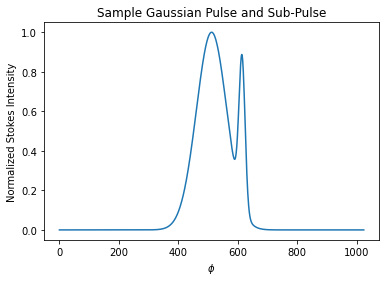

In [6]:
def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

phi_bins = 1024
pulse = gaussian(np.linspace(0, 1, phi_bins), 0.5, 0.05) + 0.15*gaussian(np.linspace(0, 1, phi_bins), 0.6, 0.01)
pulse /= max(pulse)

plt.plot(pulse)
plt.xlabel(r'$\phi$')
plt.ylabel('Normalized Stokes Intensity')
plt.title('Sample Gaussian Pulse and Sub-Pulse')

In [ ]:
true_freq = 25
df = 9.7e-4
true_bin = true_freq/df
true_bin

In [7]:
#  Full code with discription  Reyn


def harmonics(prof, f_true, df):
    
    """This function calculates the array of frequency-domain harmonics for a given pulse profile.

    Inputs:
    _______
            prof (ndarray): pulse phase profile
            f_true (float): true rotational frequency in Hz
            df (float)    : frequency bin width in target spectrum

    Returns:
    ________
            harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                    [cycles] number of Delta functions
    """
    #currently we are calculating the first 10 harmonics in the 2 bins on either side of the true value (2 + 2 = 4)
    harmonics = np.zeros((40))
    bins = np.zeros((40)).astype(int)

    #take the fft of the pulse
    prof_fft = rfft(prof)
    
    #now evaluate sinc-modified power at each of the first 10 harmonics
    for i in range(1, 11):
        f_harm = i*f_true
        bin_true = f_harm/df
        bin_below = np.floor(bin_true)
        bin_above = np.ceil(bin_true)

        #use 2 bins on either side
        current_bins = np.array([bin_below - 1, bin_below, bin_above, bin_above + 1])
        bins[(i - 1)*4:(i - 1)*4+4] = current_bins
        amplitude = prof_fft[i]*sinc(np.pi*(bin_true - current_bins))
        harmonics[(i - 1)*4:(i - 1)*4+4] = np.abs(amplitude)**2

    return bins, harmonics

In [8]:


# continuation plotting harmonics 
nbins = 300000

bins, harm = harmonics(pulse, true_freq, df)
freq = np.zeros(nbins)
freq[bins] = harm
plt.plot(np.arange(0, nbins, 1)*df, freq)
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Power')
plt.title('Sinc-Approximated Harmonics of our Pulse')


NameError: name 'true_freq' is not defined